In [1]:
from MAD import *
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
%load_ext autoreload
%autoreload 2

In [9]:
true_x_0,true_gamma=med,MAD

In [5]:
T=100000
t0=time.time()
N=1001
med,MAD=-2,3
Gibbs=Gibbs_med_MAD(T=T,N=N,med=med,MAD=MAD,distribution="cauchy",par_prior_loc=[0,3],par_prior_scale=[2,2],std_prop_loc=0.1,std_prop_scale=0.1)
t_gibbs=time.time()-t0

100%|██████████| 100000/100000 [02:18<00:00, 724.38it/s]


Acceptation rates MH : loc = 0.00% scale = 77.11% 


In [6]:
def ABC_iter(par):
    np.random.seed()
    N=1001
    if time.time()-t0b<t_gibbs:
        x_0=scipy.stats.cauchy(loc=par_prior[0],scale=par_prior[1]).rvs(1)[0]
        #x_0=np.random.normal(loc=0,scale=3)
        gamma=np.random.gamma(shape=par_prior[2],scale=par_prior[3])
        y=scipy.stats.cauchy.rvs(loc=x_0,scale=gamma,size=N)
        D=np.linalg.norm(medMAD(y)-np.array([med,MAD]))
        return [x_0,gamma,D]
    return [None,None,None]

In [7]:
from multiprocessing import Pool,cpu_count


processes = cpu_count() # we performed our experiments on a machine with 8 cores
t0b=time.time()

with Pool(processes) as pool:
    processed = pool.map(ABC_iter, range(1000000))
abc=pd.DataFrame(np.array(processed).T,index=["x_0","gamma","Dist"]).T

shape1=abc.shape[0]
abc=abc.dropna()
print("{} NA values were dropped".format(shape1-abc.shape[0]))
abc.sort_values(by="Dist",inplace=True)
abc.head()

282468 NA values were dropped


,x_0,gamma,Dist
253190,-2.14029,3.198134,0.002369
446886,-2.081229,3.079865,0.008599
170103,-1.962806,3.174933,0.0092
736836,-1.883908,3.063788,0.013507
11588,-2.134495,3.190755,0.014465


In [12]:
Gibbs["chains"]["scale"]

array([3.        , 2.91780183, 3.10835629, ..., 3.08656864, 3.10702024,
       3.01115557])

/Users/antoineluciano/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

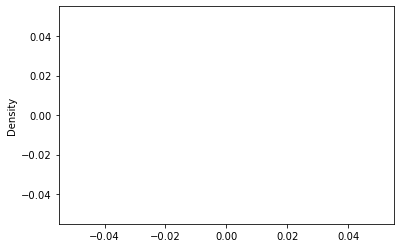

In [15]:
sns.kdeplot(Gibbs["chains"]["loc"])

epsilon = 1.9437836552739927


/Users/antoineluciano/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


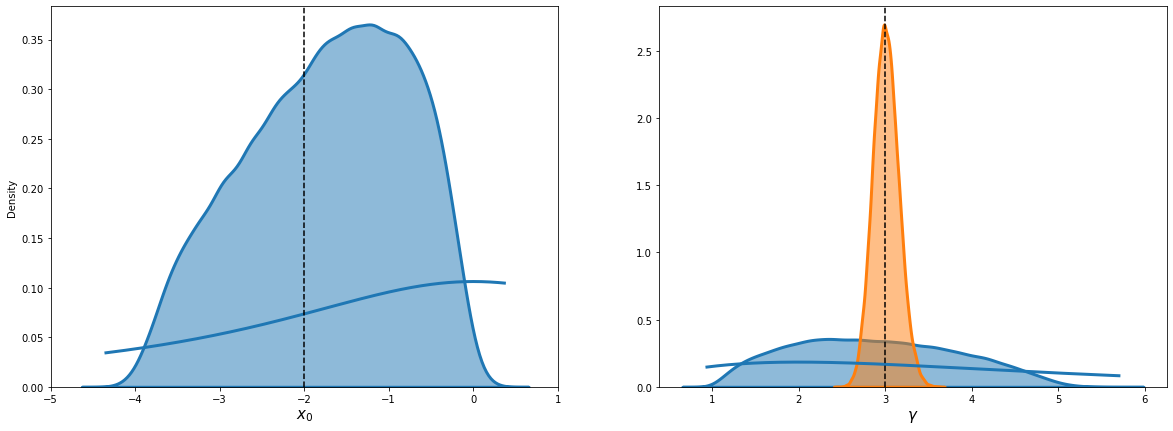

In [13]:
eps=abc["Dist"].iloc[T]
print("epsilon =",eps)
f,ax=plt.subplots(1,2,figsize=(20,7))

sns.kdeplot(abc["x_0"].iloc[:T],label="ABC",ax=ax[0],fill=True,alpha=0.5,lw=3)
sns.kdeplot(Gibbs["chains"]["loc"],label="Gibbs",ax=ax[0],fill=True,alpha=0.5,lw=3)

x=np.linspace(np.min(abc["x_0"].iloc[:T]),np.max(abc["x_0"].iloc[:T]),1000)
ax[0].plot(x,scipy.stats.cauchy.pdf(x,loc=par_prior[0],scale=par_prior[1]),label="Prior",lw=3)
ax[0].axvline(x=true_x_0,color="black",label="True value",linestyle="--")
ax[0].set_xlabel("$x_0$",fontsize=15)
ax[0].set_xlim([true_x_0-true_gamma,true_x_0+true_gamma])

sns.kdeplot(abc["gamma"].iloc[:T],label="ABC",ax=ax[1],fill=True,alpha=0.5,lw=3)
sns.kdeplot(Gibbs["chains"]["scale"],label="Gibbs",ax=ax[1],fill=True,alpha=0.5,lw=3)

x=np.linspace(np.min(abc["gamma"].iloc[:T]),np.max(abc["gamma"].iloc[:T]),1000)
ax[1].plot(x,scipy.stats.gamma.pdf(x,a=par_prior[2],scale=par_prior[3]),label="Prior",lw=3)
ax[1].axvline(x=true_gamma,color="black",label="True value",linestyle="--")
ax[1].set_xlabel("$\gamma$",fontsize=15)
ax[1].set_ylabel("",fontsize=15)
#ax[1].set_xlim([0.75*true_gamma,1.25*true_gamma])

plt.savefig("ABC_Gibbs.png")
#plt.legend()